# TP 4: Approximation of the derivatives and Quasi-Newton methods

In [29]:
import numpy as np
from numpy import *
import scipy.linalg
import scipy.optimize
from scipy.sparse import spdiags
from scipy.sparse import identity
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm
import time
from scipy.sparse import diags 

We remind the functions defined in the previous TPs

In [30]:
def ndim_rosenbrock(x, a=1,b=100):
    """Compute the Rosenbrock function"""
    n=len(x)
    s=0
    for i in range(n-1):
        s=s+b*(x[i+1]-x[i]**2)**2+(a-x[i])**2
    return s


def ndim_grad_rosenbrock(x, a=1,b=100):
    """Computation  of the analytical form of the
    gradient of the Rosenbrock function"""
    n=len(x)
    g = np.zeros(n)
    g[0]= 2*(x[0]-a) -4*b*x[0]*(x[1]-x[0]**2)
    for i in range(1,n-1):
        g[i]= 2*b*(x[i]-x[i-1]**2)+2*(x[i]-a) -4*b*x[i]*(x[i+1]-x[i]**2)
    g[-1] = 2*b*(x[-1]-x[-2]**2)
    return g

def ndim_hess_rosenbrock(x, a=1,b=100):
    """Computation  of the analytical form of the
    Hessian of the Rosenbrock function"""
    n=len(x)
    h = np.zeros((n,n))
    h[0][0] = -4*b*x[1]+12*b*x[0]**2+2
    h[0][1] = -4*b*x[0]
    for i in range(1,n-1):
        h[i][i]= 2*b-4*b*x[i+1]+12*b*x[i]**2+2
        h[i][i-1]=-4*b*x[i-1]
        h[i][i+1]=-4*b*x[i]
    h[-1][-1] = 2*b
    h[-1][-2] = -4*b*x[-2]
    return h

# Finite differences

Code the forward and the central finite differences 

In [31]:
def finite_diff(f, fx,x,h):
    """
    Compute the first order derivatives of the function f
    in the point x using forward finite differences

    x: the point where to compute the finite differences
    fx: f(x)
    h: discretization parameter 
    """
    n = len(x)
    grad = np.zeros(n)
    for i in range(n):
      x_temp = x.copy()
      x_temp[i] += h
      grad[i] = (f(x_temp) - fx) / h
    return grad



def finite_diffc(f,x,h):
  """
  Compute the first order derivative of the function f
  on the point x using central finite differences
  x: the point where to compute the finite differences
  h: discretization parameter 
  """
  n = len(x)
  grad = np.zeros(n)
  for i in range(n):
    x_temp1 = x.copy()
    x_temp2 = x.copy()
    x_temp1[i] += h
    x_temp2[i] -= h
    grad[i] = (f(x_temp1) - f(x_temp2)) / (2 * h)
  return grad



Study the dependence on $h$ of the approximation error commited by the finite differences: plot the absolute error for the two schemes and the theoretical bound.

Which is the best value of $h$ for the two schemes? 

Are the results coherent with the theory ?

1e-08
1e-06


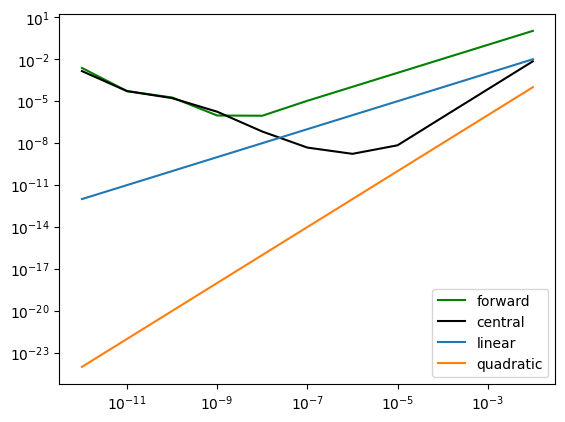

In [32]:
n=2
x=np.random.rand(n,)
g=ndim_grad_rosenbrock(x)
fx=ndim_rosenbrock(x)
errorf=[] # absolute error on the forward finite differences 
errorc=[] # absolute error on the central finite differences 
xx=[] # values of h
yy1=[] # theoretical bound on the on the forward finite differences
yy2=[] # theoretical bound on the on the central finite differences

for i in range(-12,-1):
  h=10**i

  xx.append(h)
  grad_finite_diff = finite_diff(ndim_rosenbrock, fx, x, h)
  grad_finite_diffc = finite_diffc(ndim_rosenbrock, x, h)
  errorf.append(linalg.norm(g - grad_finite_diff))
  errorc.append(linalg.norm(g - grad_finite_diffc))
  yy1.append(h)
  yy2.append(h**2)

plt.loglog(xx,errorf,'g',label='forward')
plt.loglog(xx,errorc,'k',label='central')
plt.loglog(xx,yy1,label='linear')
plt.loglog(xx,yy2,label='quadratic')
plt.legend()
j=argmin(errorf)
print(xx[j])
j=argmin(errorc)
print(xx[j])




Insert the optimal value of $h$ in the finite differences

In [33]:
def finite_diff(f, fx,x):
    """
    Compute the first order derivative of the function f
    on the point x using forward finite differences

    x: the point where to compute the finite differences
    fx: f(x)
    """
    n = len(x)
    grad = np.zeros(n)
    for i in range(n):
      x_temp = x.copy()
      x_temp[i] += h
      grad[i] = (f(x_temp) - fx) / h
    return grad

def finite_diffc(f,x):
  """
  Compute the first order derivative of the function f
  on the point x using central finite differences
  x: the point where to compute the finite differences
  fx: f(x)
  """
  n = len(x)
  grad = np.zeros(n)
  for i in range(n):
    x_temp1 = x.copy()
    x_temp2 = x.copy()
    x_temp1[i] += h
    x_temp2[i] -= h
    grad[i] = (f(x_temp1) - f(x_temp2)) / (2 * h)
  return grad


In the gradient method with backtrack insert an option to approximate the gradient by finite differences. Use the variable "exact":

* exact = 1 no approximation
* exact = 0 forward finite difeerences
* exact = -1 central finite differences 




In [34]:
def backtracking( f, fx,gx,x, p , alpha0=1,b_max = 20, gamma = 0.1, c1 = 0.0001):
    alpha = alpha0
    i = 0
    finish=False
    while i<b_max and not(finish):
        i=i+1
        
        #if the Armijo condition is verified we stop the backtracking
        if f(x + alpha*p) < fx + alpha*c1*np.dot(gx, p):
            finish = True
            
        else:
            alpha *= gamma
    if finish:
        return alpha, i
    else:
        raise Exception("Backtraking failed !") #if we go pass b_max interation of
                                      #the backtracking loop, the feasable interval
                                      #is too small, we raise an error
                   

def steepest_descent_backtrack(x,obj,grad,tol,maxit,exact):
    k=0
    n=x.shape[0] 
    err=[linalg.norm(xT-x)/linalg.norm(xT)]
    fx=obj(x)

    if exact == 1:
        g = grad(x)
    elif exact == 0:
        g = finite_diff(obj, fx, x)
    elif exact == -1:
        g = finite_diffc(obj, x)
    elif exact == -2:
        g = complex_step(obj, x, 1.e-11)

    fval=[fx]
    gval=[linalg.norm(g)]
    step=[]
    countf=n
    alpha0=1
    xold=x
    gold=g
    while k<maxit:
        k=k+1
        alpha,countfp=backtracking( obj, fx,g,x, -g,alpha0)
        step.append(alpha)
        countf=countf+countfp
        
        
        x=x-alpha*g
        fx=obj(x)
        fval.append(fx)
        err.append(linalg.norm(xT-x)/linalg.norm(xT))
        
        if exact == 1:
            g = grad(x)
        elif exact == 0:
            g = finite_diff(obj, fx, x)
            countf += n
        elif exact == -1:
            g = finite_diffc(obj, x)
            countf += n
        elif exact == -2:
            g = complex_step(obj, x, 1.e-11)
          
        
        gval.append(linalg.norm(g))
        sk=x-xold
        alpha0=np.dot(sk,sk)/np.dot(sk,g-gold)
        xold=x.copy()
        
        gold=g.copy()
        #print(np.linalg.norm(g))
        if np.linalg.norm(g)<tol :
            print('Number of iterations for gradient method with backtrack: ' + str(k))
            print('Number of function evaluations for gradient method with backtrack: ' + str(countf))
            return x,fval,err,gval,step
    print('Maximum number of iterations reached for gradient method  with backtrack')
    print('Gradient norm :'  + str(np.linalg.norm(g)))
    return x,fval,err,gval,step



Solve the test problem. 



* Does the accuracy on the solution change? 

* Does the rate of convergence change? 

* Does the computational time change (choose large n!)? Update the counter of function evaluations taking into account the evaluations performed to approximate the derivatives. 
Consider both the time to compute a single gradient approximation and the total time for the gradient method. 


In [35]:
n=500
x0=1.2*np.ones((n,))

t = time.process_time()
g = ndim_grad_rosenbrock(x0)
t = time.process_time() - t

print('Time for exact gradient computation: ' + str(t))

t = time.process_time()
g1 = finite_diff(ndim_rosenbrock, ndim_rosenbrock(x0), x0)
t = time.process_time() - t

print('Time for forward difference approximation: ' + str(t))

t = time.process_time()
g2 = finite_diffc(ndim_rosenbrock, x0)
t = time.process_time() - t

print('Time for central difference approximation: ' + str(t))

Time for exact gradient computation: 0.001546999999999521
Time for forward difference approximation: 0.3312929999999996
Time for central difference approximation: 0.32219000000000086


In [36]:
tol=1.e-6
maxit=4000
n=40
x0=1.2*np.ones((n,))
xT=np.ones((n,))

t = time.process_time()
solg, fvalg, errg, gvalg, stepg = steepest_descent_backtrack(x0, ndim_rosenbrock, ndim_grad_rosenbrock, tol, maxit, 1)
t = time.process_time() - t
print('Time for exact gradient method: ' + str(t))

t = time.process_time()
solgf, fvalgf, errgf, gvalgf, stepgf = steepest_descent_backtrack(x0, ndim_rosenbrock, ndim_grad_rosenbrock, tol, maxit, 0)
t = time.process_time() - t
print('Time for forward differences gradient method: ' + str(t))

t = time.process_time()
solgc, fvalgc, errgc, gvalgc, stepgc = steepest_descent_backtrack(x0, ndim_rosenbrock, ndim_grad_rosenbrock, tol, maxit, -1)
t = time.process_time() - t
print('Time for central differences gradient method: ' + str(t))

fig1,ax1 = plt.subplots()
ax1.semilogy(errg,'k',label='gradient')
ax1.semilogy(errgf,'g',label='gradient forward')
ax1.semilogy(errgc,'b',label='gradient central')
ax1.set_title('Error')
legend = ax1.legend()

fig2,ax2 = plt.subplots()
ax2.semilogy(fvalg,'k',label='gradient')
ax2.semilogy(fvalgf,'g',label='gradient forward')
ax2.semilogy(fvalgc,'b',label='gradient central')
ax2.set_title('Objective function')
legend = ax2.legend()

fig3,ax3 = plt.subplots()
ax3.semilogy(gvalg,'k',label='gradient')
ax3.semilogy(gvalgf,'g',label='gradient forward')
ax3.semilogy(gvalgc,'b',label='gradient central')
ax3.set_title('Norm of the gradient')
legend = ax3.legend()


fig4,ax4 = plt.subplots()
ax4.semilogy(stepg,'k',label='gradient')
ax4.semilogy(stepgf,'g',label='gradient forward')
ax4.semilogy(stepgc,'b',label='gradient central')
ax4.set_title('Step length')
legend = ax4.legend()

Number of iterations for gradient method with backtrack: 535
Number of function evaluations for gradient method with backtrack: 840
Time for exact gradient method: 0.07055300000000031


Exception: Backtraking failed !

# Quasi Newton: BFGS

Code the BFGS method with backtracking.

In [37]:
def bfgs_backtrack(x,obj,grad,tol,maxit):
    k=0
    n=len(x)
    g=grad(x)
    fx=obj(x)
    fval=[fx]
    err=[linalg.norm(xT-x)/linalg.norm(xT)]
    gval=[linalg.norm(g)]
    step=[]
    countf=0
    xold=np.copy(x)
    gold=np.copy(g)
    while k<maxit:
        # Compute the search direction
        if k == 0:
            B = np.eye(n)  # Initialize B as the identity matrix
        else:
            sk = x - xold
            yk = g - gold
            B = newB(sk, yk, B)

        p = -np.dot(B, g)

        # Perform backtracking line search
        alpha, countfp = backtracking(obj, fx, g, x, p)
        countf += countfp
        step.append(alpha)

        # Update x
        xold = np.copy(x)
        gold = np.copy(g)
        x = x + alpha * p
        
        fx=obj(x)
        fval.append(fx)
        err.append(linalg.norm(xT-x)/linalg.norm(xT))
        #err.append(linalg.norm(xT-x))
     
        g=grad(x)
        #g=finite_diff(obj, fx, x, "grad")
        gval.append(linalg.norm(g))
        
        
        
        
        
        
        #print(np.linalg.norm(g))
        if np.linalg.norm(g)<tol :
            print('Number of iterations for BFGS with backtrack : '+ str(k) )
            print('Number of function evaluations for BFGS : '+ str(countf))
            return x,fval,err,gval,step
    print('Maximum number of iterations reached for BFGS method with backtrack ')    
    return x,fval,err,gval,step


def newB(sk,yk,B):
    rho = 1.0 / np.dot(yk, sk)
    I = np.eye(len(B))
    Vk = I - rho * np.outer(sk, yk)
    B = np.dot(Vk, np.dot(B, Vk.T)) + rho * np.outer(sk, sk)
    return B


Test the BFGS method on our test problem and compare it with the gradient and the Newton's method. Comment on the results



In [38]:
def newton_backtrack(x,obj,grad,hess,tol,maxit):
    k=0
    g=grad(x);
    H=hess(x);
    
    fx=obj(x)
    fval=[fx]
    err=[linalg.norm(xT-x)/linalg.norm(xT)]
    gval=[linalg.norm(g)]
    step=[]
    ratio=[]
    countf=0 # number of function evaluations
    while k<maxit:
        k=k+1
        if np.all(np.linalg.eigvals(H) > 0):
            p=linalg.solve(H,-g)
        else: 
            raise("Not positve definite!")
        alpha,countfp=backtracking( obj, fx,g,x, p)
        countf=countf+countfp
        step.append(alpha)
        xold=x
        x=x+alpha*p
        ratio.append(linalg.norm(xT-x)/linalg.norm(xT-xold)**2)
        fx=obj(x)
        fval.append(fx)
        err.append(linalg.norm(xT-x)/linalg.norm(xT))
     
        g=grad(x)
        gval.append(linalg.norm(g))
        H=hess(x)
        #print(np.linalg.norm(g))
        if np.linalg.norm(g)<tol :
            print('Number of iterations for Newton method with backtrack : '+ str(k) )
            print('Number of function evaluations for Newton method with backtrack : '+ str(countf) )

            
            return x,fval,err,gval,step
    print('Maximum number of iterations reached for Newton method with backtrack ')    
    return x,fval,err,gval,step




Number of iterations for gradient method with backtrack: 1019
Number of function evaluations for gradient method with backtrack: 1570
Number of iterations for Newton method with backtrack : 8
Number of function evaluations for Newton method with backtrack : 8
Number of iterations for BFGS with backtrack : 0
Number of function evaluations for BFGS : 58011


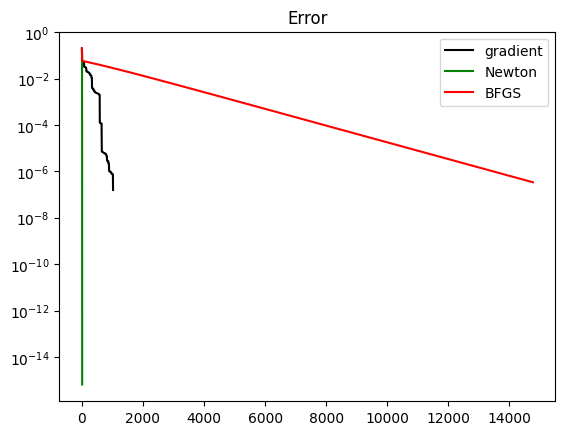

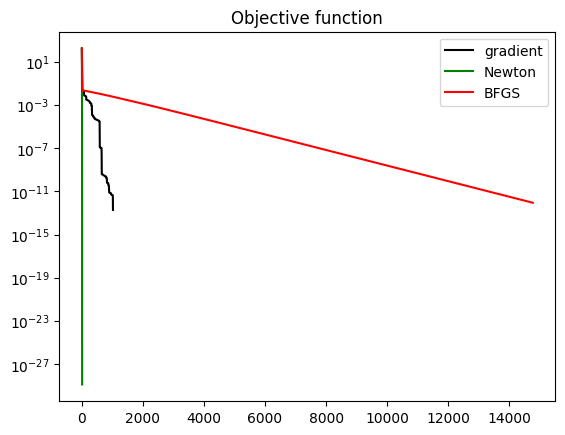

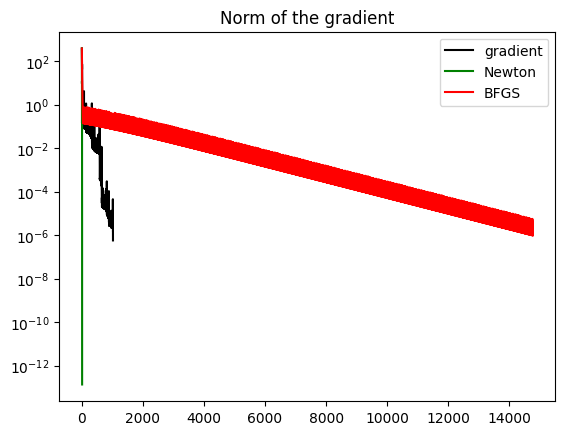

In [40]:
tol=1.e-6
maxit=4000
n=30
x0=1.2*np.ones((n,))
xT=np.ones((n,))


solg, fvalg, errg, gvalg, stepg = steepest_descent_backtrack(x0, ndim_rosenbrock, ndim_grad_rosenbrock, tol, maxit, 1)
soln, fvaln, errn, gvaln, stepn = newton_backtrack(x0, ndim_rosenbrock, ndim_grad_rosenbrock, ndim_hess_rosenbrock, tol, maxit)
solb, fvalb, errb, gvalb, stepb = bfgs_backtrack(x0, ndim_rosenbrock, ndim_grad_rosenbrock, tol, maxit)

fig1,ax1 = plt.subplots()
ax1.semilogy(errg,'k',label='gradient')
ax1.semilogy(errn,'g',label='Newton')
ax1.semilogy(errb,'r',label='BFGS')
ax1.set_title('Error')
legend = ax1.legend()

fig2,ax2 = plt.subplots()
ax2.semilogy(fvalg,'k',label='gradient')
ax2.semilogy(fvaln,'g',label='Newton')
ax2.semilogy(fvalb,'r',label='BFGS')
ax2.set_title('Objective function')
legend = ax2.legend()

fig3,ax3 = plt.subplots()
ax3.semilogy(gvalg,'k',label='gradient')
ax3.semilogy(gvaln,'g',label='Newton')
ax3.semilogy(gvalb,'r',label='BFGS')
ax3.set_title('Norm of the gradient')
legend = ax3.legend()




Use now the Trid function as test function

In [41]:
#TRID FUNCTION
# https://www.sfu.ca/~ssurjano/trid.html
def trid(x):
  d = len(x)
  sum1 = (x[0]-1)**2
  sum2 = 0

  for i in range(d-1):
  
    xold = x[i]
    sum1 = sum1 + (x[i+1]-1)**2
    sum2 = sum2 + x[i+1]*xold
    
  return  sum1 - sum2

def grad_trid(x):
  d = len(x)
  g = np.zeros((d,))

  g[0]=2*(x[0]-1)-x[1]
  g[-1]=2*(x[-1]-1)-x[d-2]
  for i in range(d-2):
    
    i=i+1
    g[i]=2*(x[i]-1)-x[i-1]-x[i+1]
    
  return  g

def hess_trid(x):
  d = len(x)
  h=diags([-1, 2, -1], [-1, 0, 1], shape=(d, d)).toarray()
  return  h


In [42]:
n=500
#n=1000
x0=1.2*np.ones((n))
xT=np.ones((n))
maxit=15000
tol=1.e-1
for i in range(n):
  xT[i]=(i+1)*(n-i)

solb,fvalb,errb,gvalb,stepb=bfgs_backtrack(x0,trid,grad_trid,tol,maxit)
solg,fvalg,errg,gvalg,stepg=steepest_descent_backtrack(x0,trid,grad_trid,tol,maxit,1)
soln,fvaln,errn,gvaln,stepn=newton_backtrack(x0,trid,grad_trid,hess_trid,tol,maxit)


fig1,ax1 = plt.subplots()
ax1.semilogy(errg,'k',label='gradient')
ax1.semilogy(errn,'g',label='Newton')
ax1.semilogy(errb,'r',label='BFGS')
ax1.set_title('Error')
legend = ax1.legend()

fig2,ax2 = plt.subplots()
ax2.plot(fvalg,'k',label='gradient')
ax2.plot(fvaln,'g',label='Newton')
ax2.plot(fvaln,'r',label='BFGS')
ax2.set_title('Objective function')
legend = ax2.legend()

fig3,ax3 = plt.subplots()
ax3.semilogy(gvalg,'k',label='gradient')
ax3.semilogy(gvaln,'g',label='Newton')
ax3.semilogy(gvalb,'r',label='BFGS')
ax3.set_title('Norm of the gradient')
legend = ax3.legend()





KeyboardInterrupt: 

# Approximation of the Hessian
 
Optional: compute the Hessian approximation by finite differences using first the gradient analytical expression and then the second order finite differences. How does the computational time change?

In [ ]:
def finite_diffH(g, gx,x):
    #if we know the gradient
    # COMPLETE



def finite_diffH2(func,initial,delta=1e-3):
  #if we don't know the gradient
  # COMPLETE
  return output


In [ ]:
x0=2*np.ones(100)

t = time.process_time()
H=ndim_hess_rosenbrock(x0)
t = time.process_time()-t
print('Time for exact Hessian: ' + str(t))

t = time.process_time()
H1=finite_diffH(ndim_grad_rosenbrock,ndim_grad_rosenbrock(x0),x0)
t = time.process_time()-t
print('Time for first order differences approximation: ' + str(t))

t = time.process_time()
H2=finite_diffH2(ndim_rosenbrock,x0)
t = time.process_time()-t
print('Time for second order differences approximation: ' + str(t))





# The complex step

Optiona: A better way to nuumerically approximate the derivatives is given by the complex step: 
https://nhigham.com/2020/10/06/what-is-the-complex-step-approximation/

This provides an error of the order of $O(h^2)$, requires a single evaluation of $f$ and it is not prone to numerical cancellation.

Try to implement the complex step and study the dependence of the approximation error on $h$. Use this in the gradient method and compare it with the finite differences.

In [ ]:
def complex_step(f,x,h):
    """
    Compute the first order derivatives of the function f
    in the point x using the complex step


    x: the point where to compute the finite differences
    fx: f(x)
    h: discretization parameter 
    
    """
    # COMPLETE


In [ ]:
n=2
x=np.random.rand(n,)
g=ndim_grad_rosenbrock(x)

errorcs=[]
xx=[]
yy=[]

for i in range(-12,-1):
  h=10**(i)
  xx.append(h)
  yy.append(h**2)
  gcs=complex_step(ndim_rosenbrock,x,h)
  errorcs.append(linalg.norm(g-gcs))
  

plt.loglog(xx,errorcs,'g',label='complex step')
plt.loglog(xx,yy,label='quadratic')
plt.legend()
j=argmin(errorcs)
print(xx[j])



In [ ]:
def steepest_descent_backtrack(x,obj,grad,tol,maxit,exact):
    k=0
    n=x.shape[0] 
    err=[linalg.norm(xT-x)/linalg.norm(xT)]
    fx=obj(x)
    if exact==1:
      g=grad(x)
    elif exact==0:
      g=finite_diff(obj, fx, x)
    elif exact==-1:
      g=finite_diffc(obj, x)
    elif exact==-2:
      g=complex_step(obj,x,1.e-11)
    fval=[fx]
    gval=[linalg.norm(g)]
    step=[]
    countf=n
    alpha0=1
    xold=x
    gold=g
    while k<maxit:
        k=k+1
        alpha,countfp=backtracking( obj, fx,g,x, -g,alpha0)
        step.append(alpha)
        countf=countf+countfp
        
        
        x=x-alpha*g
        fx=obj(x)
        fval.append(fx)
        err.append(linalg.norm(xT-x)/linalg.norm(xT))
        if exact==1:
          g=grad(x)
        elif exact==0:
          g=finite_diff(obj, fx, x)
          countf=countf+n
          # check correctness of the approx
          #g1=grad(x)
          #print(max(abs(g-g1)))
          
        elif exact==-1:
          g=finite_diffc(obj, x)
          countf=countf+n
        elif exact==-2:
          g=complex_step(obj,x,1.e-11)
        
        gval.append(linalg.norm(g))
        sk=x-xold
        alpha0=np.dot(sk,sk)/np.dot(sk,g-gold)
        xold=x.copy()
        
        gold=g.copy()
        #print(np.linalg.norm(g))
        if np.linalg.norm(g)<tol :
            print('Number of iterations for gradient method with backtrack: ' + str(k))
            print('Number of function evaluations for gradient method with backtrack: ' + str(countf))
            return x,fval,err,gval,step
    print('Maximum number of iterations reached for gradient method  with backtrack')
    print('Gradient norm :'  + str(np.linalg.norm(g)))
    return x,fval,err,gval,step

In [ ]:
n=500
x0=1.2*np.ones((n,))


t = time.process_time()
g=ndim_grad_rosenbrock(x0)
t = time.process_time()-t
print('Time for exact gradient computation: ' + str(t))
t = time.process_time()
g1=finite_diff(ndim_rosenbrock,ndim_rosenbrock(x0),x0)
t = time.process_time()-t
print('Time for forward difference approximation: ' + str(t))
t = time.process_time()
g1=finite_diffc(ndim_rosenbrock,x0)
t = time.process_time()-t
print('Time for central difference approximation: ' + str(t))
t = time.process_time()
g1=complex_step(ndim_rosenbrock,x0,1e-11)
t = time.process_time()-t
print('Time for complex step approximation: ' + str(t))



In [ ]:

tol=1.e-6
maxit=400
n=50
x0=1.2*np.ones((n,))
xT=np.ones((n,))

t = time.process_time()
solg,fvalg,errg,gvalg,stepg=steepest_descent_backtrack(x0,ndim_rosenbrock,ndim_grad_rosenbrock,tol,maxit,1)
t = time.process_time()-t
print('Time for exact gradient method: ' + str(t))
t = time.process_time()
solgf,fvalgf,errgf,gvalgf,stepgf=steepest_descent_backtrack(x0,ndim_rosenbrock,ndim_grad_rosenbrock,tol,maxit,0)
t = time.process_time()-t
print('Time for forward differences gradient method: ' + str(t))
t = time.process_time()
solgc,fvalgc,errgc,gvalgc,stepgc=steepest_descent_backtrack(x0,ndim_rosenbrock,ndim_grad_rosenbrock,tol,maxit,-1)
t = time.process_time()-t
print('Time for central differences gradient method: ' + str(t))
t = time.process_time()
solgcs,fvalgcs,errgcs,gvalgcs,stepgcs=steepest_descent_backtrack(x0,ndim_rosenbrock,ndim_grad_rosenbrock,tol,maxit,-2)
t = time.process_time()-t
print('Time for complex step gradient method: ' + str(t))





fig1,ax1 = plt.subplots()
ax1.semilogy(errg,'k',label='gradient')
ax1.semilogy(errgf,'g',label='gradient forward')
ax1.semilogy(errgc,'b',label='gradient central')
ax1.semilogy(errgcs,'m',label='gradient complex step')
ax1.set_title('Error')
legend = ax1.legend()

fig2,ax2 = plt.subplots()
ax2.semilogy(fvalg,'k',label='gradient')
ax2.semilogy(fvalgf,'g',label='gradient forward')
ax2.semilogy(fvalgc,'b',label='gradient central')
ax2.semilogy(fvalgcs,'m',label='gradient complex step')
ax2.set_title('Objective function')
legend = ax2.legend()

fig3,ax3 = plt.subplots()
ax3.semilogy(gvalg,'k',label='gradient')
ax3.semilogy(gvalgf,'g',label='gradient forward')
ax3.semilogy(gvalgc,'b',label='gradient central')
ax3.semilogy(gvalgcs,'m',label='gradient complex step')
ax3.set_title('Norm of the gradient')
legend = ax3.legend()


fig4,ax4 = plt.subplots()
ax4.semilogy(stepg,'ok',label='gradient')
ax4.semilogy(stepgf,'og',label='gradient forward')
ax4.semilogy(stepgc,'ob',label='gradient central')
ax4.semilogy(stepgcs,'om',label='gradient complex step')
ax4.set_title('Step sizes')
legend = ax3.legend()
